# Data processing

In this notebook, I am loading a list of molecules I obtained from ChEMBL and processing them to make sure I have:
- Standard SMILES representation of the compound
- InChIKey associated to the compound

In [1]:
# In this codeblock I will import the necessary packages and specify the paths to relevant folders
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import umap
import sys

sys.path.append('../src') 
DATAPATH = "../data"
FIGUREPATH = "../figures/"


In [2]:
# In this codeblock I will load the data from the /data folder to a Pandas dataframe and understand which headers it has
ch = pd.read_csv(os.path.join(DATAPATH, "chembl_selected.csv"))
ch.head()

,id,smiles
0,CNP0478798,N#CC1CCCN(C(=O)CCC2=CC=CC(F)=C2)C1
1,CNP0478798,CCC(=O)C1=CN=C2C=CC(C3=CC(Cl)=C(O)C(OC)=C3)=CC...
2,CNP0478798,C/C(=N\NC(=O)C1=NC2=C(C(=O)N1)C1CCCN1C(=O)N2C1...
3,CNP0478798,CC(=O)N[C@H]1[C@H](SCCCN2C=C(CN3C(=O)C4=CC=CC5...
4,CNP0478798,OC1=C(/C=N/C2=NC=CS2)C2=CC=CC=C2N1


In [3]:
ch.shape

(1100, 2)

In [4]:
# In this codeblock I will convert the molecules to standard SMILES by using the function standardise_smiles from /src
# I will import the function directly from src, not copying it here
from smiles_processing import standardise_smiles

smiles_list = ch['smiles'].tolist()
ch['standardized_smiles'] = standardise_smiles(smiles_list)

[21:55:56] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 7 9 10 11 12 14


In [5]:
ch.isna().sum()

id                      0
smiles                  0
standardized_smiles    10
dtype: int64

In [6]:
ch.dropna(subset=['standardized_smiles'], inplace=True)

In [7]:
ch.head()

,id,smiles,standardized_smiles
0,CNP0478798,N#CC1CCCN(C(=O)CCC2=CC=CC(F)=C2)C1,N#CC1CCCN(C(=O)CCc2cccc(F)c2)C1
1,CNP0478798,CCC(=O)C1=CN=C2C=CC(C3=CC(Cl)=C(O)C(OC)=C3)=CC...,CCC(=O)c1cnc2ccc(-c3cc(Cl)c(O)c(OC)c3)cc2c1Nc1...
2,CNP0478798,C/C(=N\NC(=O)C1=NC2=C(C(=O)N1)C1CCCN1C(=O)N2C1...,C/C(=N\NC(=O)c1nc2c(c(=O)[nH]1)C1CCCN1C(=O)N2c...
3,CNP0478798,CC(=O)N[C@H]1[C@H](SCCCN2C=C(CN3C(=O)C4=CC=CC5...,CC(=O)N[C@@H]1[C@@H](O)[C@H](O)[C@@H](CO)O[C@H...
4,CNP0478798,OC1=C(/C=N/C2=NC=CS2)C2=CC=CC=C2N1,Oc1[nH]c2ccccc2c1/C=N/c1nccs1


In [8]:
ch.dtypes

id                     object
smiles                 object
standardized_smiles    object
dtype: object

In [9]:
output_file = os.path.join(DATAPATH, "chembl_processed.csv")
ch.to_csv(output_file, index=False)

# Model Bias Evaluation

I have used eos30f3 Model to make predictions on the above dataset.

The formulation of the problem involves using machine learning, specifically the ChemProp network (D-MPNN), to predict whether a molecule is a blocker of the hERG channel. The input to the model is a molecular structure represented in a format suitable for processing by the ChemProp network. This could include SMILES strings or other molecular representations. The output of the model is a prediction of the likelihood or probability that the molecule blocks the hERG channel.


In [10]:
# In this codeblock I will am predicting using Ersilia and saving in the /data folder
from ersilia import ErsiliaModel

em = ErsiliaModel("eos30f3")

In [11]:
em.serve()

In [12]:
ch_standardized = pd.read_csv(os.path.join(DATAPATH, output_file))

# Access the column "standardized_smiles" from the DataFrame
smiles_list2 = ch_standardized['standardized_smiles'].tolist()

# Now you can proceed with your further processing
data2 = em.run(smiles_list2, output="pandas")

In [13]:
data2

,key,input,activity
0,HWGPBEQLDAATTP-UHFFFAOYSA-N,N#CC1CCCN(C(=O)CCc2cccc(F)c2)C1,0.833848
1,VZEQMVMGOXXSDA-UHFFFAOYSA-N,CCC(=O)c1cnc2ccc(-c3cc(Cl)c(O)c(OC)c3)cc2c1Nc1...,0.737828
2,XPDWCQMOAYLTHH-CCVNUDIWSA-N,C/C(=N\NC(=O)c1nc2c(c(=O)[nH]1)C1CCCN1C(=O)N2c...,0.596653
3,WWAFZFZKTQQHTL-ILRYNQFESA-N,CC(=O)N[C@@H]1[C@@H](O)[C@H](O)[C@@H](CO)O[C@H...,0.384757
4,BSKQAAYIGGYUAZ-VGOFMYFVSA-N,Oc1[nH]c2ccccc2c1/C=N/c1nccs1,0.407854
...,...,...,...
1085,UWRRUNGWGYWTLN-UHFFFAOYSA-N,CC(C)C1CCC(N2CCC(N3c4ccccc4NS3(=O)=O)CC2)CC1,0.856711
1086,AHOJWFAUNHFGRL-UHFFFAOYSA-N,O=C(O)c1ccc2c(c1)N(C(=O)CNCc1ccc(F)cc1)CC(=O)N...,0.686756
1087,ZTJKDZJNWLALKP-UHFFFAOYSA-N,COc1ccc2[nH]c(=O)c(-c3cc(C)cc(C)c3)c(OCC3CCCN(...,0.873780
1088,AZLDEGGPCJQDTC-UHFFFAOYSA-N,CCC(=O)Nc1cccc2c(OCC(O)C(C)NC(C)C)cccc12,0.784640


Each row in the prediction output corresponds to a specific molecule, and the columns contain the following information:
- key: A unique identifier for each molecule.
- input: The molecular structure of the molecule, typically represented as SMILES strings.
- activity: The predicted likelihood or probability that the molecule blocks the hERG channel. This value ranges between 0 and 1, where 0 indicates very low probability and 1 indicates very high probability.
  
Interpreting the predictions:
- A high probability value (close to 1) suggests that the model is confident that the molecule is a blocker of the hERG channel.
- A low probability value (close to 0) suggests that the model is confident that the molecule is not a blocker of the hERG channel.
  Values between 0 and 1 represent varying degrees of uncertainty or confidence in the prediction.

In [14]:
data2.to_csv(os.path.join(DATAPATH, "chembl_predictions.csv"), index=False)

Now, I will use the predictions I got from the Ersilia Model Hub on the dataset of 1000 molecules curated above and see how are they distributed in their space

In [15]:
# In this codeblock I will create the necessary plots with MatPlotLib to observe the distribution of predicted values
from rdkit import Chem
from rdkit.Chem.Descriptors import qed
from rdkit.Chem.Descriptors import ExactMolWt
from rdkit.Chem.Descriptors import MolLogP

# Calculate Relevant PHYSCHEM

allsmiles = ch_standardized["smiles"].tolist()
allmols = [Chem.MolFromSmiles(smi) for smi in allsmiles]
ch_standardized["mw"] = [ExactMolWt(mol) for mol in allmols]
ch_standardized["logp"] = [MolLogP(mol) for mol in allmols]
ch_standardized["qed"] = [qed(mol) for mol in allmols]

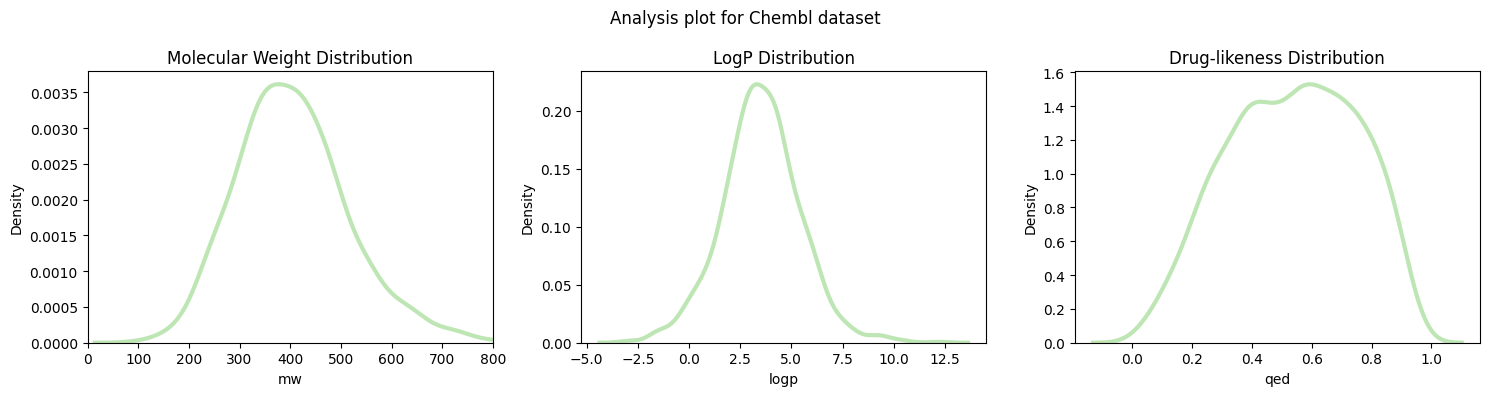

In [19]:
import seaborn as sns
k = ch_standardized
v=ch_standardized
fig, ax = plt.subplots(1,3, figsize=(15,4))
fig.suptitle("Analysis plot for Chembl dataset")

ax0 = ax[0]
ax1 = ax[1]
ax2 = ax[2]


sns.kdeplot(v["mw"], ax=ax0, color = "#bee6b4", lw=3 )
ax0.set_title("Molecular Weight Distribution")
ax0.set_xlim(0,800)

sns.kdeplot(v["logp"], ax=ax1, color = "#bee6b4", lw=3)
ax1.set_title("LogP Distribution")

sns.kdeplot(v["qed"], ax=ax2, color = "#bee6b4", lw=3)
ax2.set_title("Drug-likeness Distribution")


plt.tight_layout()
plt.savefig(os.path.join(FIGUREPATH, "chembl.png"), dpi=300)

Molecular Weight distribution:
- X-axis (Molecular Weight): This axis represents the range of molecular weights observed in the dataset. The range extends from 0 to 800, with a mean molecular weight of approximately 400. This means that the majority of molecules in the dataset have a molecular weight around 400, while some molecules may have lower or higher weights.
- Y-axis (Density): The density on the y-axis represents the probability density of observing a particular molecular weight value. In other words, it indicates the likelihood of finding a molecule with a specific molecular weight in the dataset. The density values range from 0 to 0.0035, indicating the relative frequency of molecular weights in the dataset.
- The plot shows that the distribution of molecular weights follows a normal distribution, also known as a Gaussian distribution. This distribution is characterized by a symmetric bell-shaped curve, with the majority of data points clustering around the mean value of approximately 400.

LogP distribution:
- X-axis (logP): This axis represents the range of logP values observed in the dataset. The range extends from -5 to 13, with a mean molecular weight of approximately 3.75. This means that the majority of molecules in the dataset have a molecular weight around 3.75, while some molecules may have lower or higher weights.
- Y-axis (Density): The density on the y-axis represents the probability density of observing a particular logP value. In other words, it indicates the likelihood of finding a molecule with a specific logP in the dataset. The density values range from 0 to 0.30, indicating the relative frequency of molecular weights in the dataset.
- The plot shows that the distribution of logP follows a normal distribution. This distribution is characterized by a symmetric bell-shaped curve, with the majority of data points clustering around the mean value of approximately 3.75.

Drug-likeness Distribution:
- X-axis - QED: This axis represents the QED scores of the molecules. QED scores typically range from 0 to 1, where higher values indicate that a molecule possesses more drug-like properties.
- Y-axis - Density: This axis represents the density of molecules at different QED score ranges. The density indicates the concentration of molecules within a particular QED score interval.
- Normal distribution: The plot appears to be normally distributed, which means that most molecules in the dataset have QED scores clustered around a central value (the mean). This suggests that the dataset contains a diverse range of molecules with varying degrees of drug-likeness.
- Curvature near the mean: The slight curvature in the plot around the mean (QED scores of approximately 0.4 to 0.6) indicates that there may be a higher density of molecules with QED scores in this range compared to neighboring score ranges. This could imply that there is a preferred range of drug-likeness for the molecules in the dataset.

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


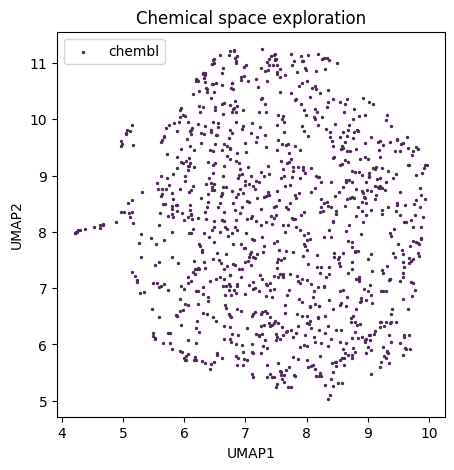

In [17]:
from lazyqsar.descriptors.descriptors import ErsiliaCompoundEmbeddings
from umap import UMAP

desc = ErsiliaCompoundEmbeddings()
ch_descs = desc.transform(ch_standardized["smiles"])
reducer = UMAP()
reducer.fit(np.vstack([ch_descs]))
umap_ch = reducer.transform(ch_descs)
fig,ax = plt.subplots(1,1, figsize=(5,5))
ax.scatter(umap_ch[:,0], umap_ch[:,1], c="#50285a", s=2, label="chembl")
ax.set_title("Chemical space exploration")
ax.set_xlabel("UMAP1")
ax.set_ylabel("UMAP2")
ax.legend()
plt.savefig(os.path.join(FIGUREPATH,"umap_chembl.png"), dpi=300)

Output is a scatter plot where each point represents a compound in the dataset. The x-axis and y-axis of the plot represent the first and second dimensions of the UMAP-transformed descriptors, respectively. These dimensions are often referred to as UMAP1 and UMAP2. Each point in the scatter plot corresponds to a compound, and its position is determined by its reduced-dimensional representation obtained through UMAP. 

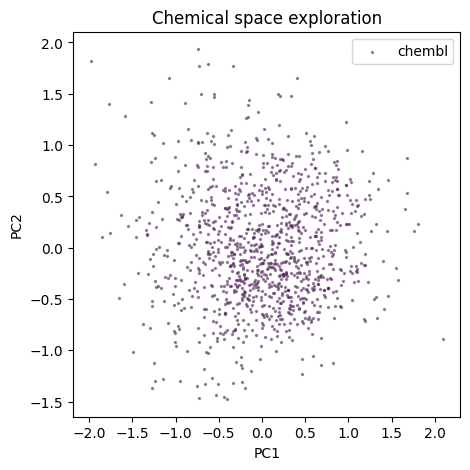

In [22]:
from sklearn.decomposition import PCA

desc = ErsiliaCompoundEmbeddings()
ch_descs = desc.transform(ch["smiles"])
reducer = PCA(n_components=4)
reducer.fit(np.vstack([ch_descs]))
pca_ch = reducer.transform(ch_descs)
fig,ax = plt.subplots(1,1, figsize=(5,5))
ax.scatter(pca_ch[:,0], pca_ch[:,1], c="#50285a", alpha =0.5, s=2, label="chembl")
ax.set_title("Chemical space exploration")
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.legend()
plt.savefig(os.path.join(FIGUREPATH,"pca_chembl.png"), dpi=300)

X-axis: The x-axis represents the first principal component (PC1) of the compounds. PC1 is the linear combination of the original descriptors that captures the maximum variance in the data.
Y-axis: The y-axis represents the second principal component (PC2) of the compounds. PC2 is orthogonal to PC1 and captures the second most significant variance in the data.
Each data point in the scatter plot represents a compound. The position of the data point is determined by its PC1 and PC2 values. Points that are closer together in the plot represent compounds that are more similar to each other based on their molecular descriptors.